In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# Step 1: Load the Data
file_path = '/Users/rohanpadaya/Desktop/pankit_assign/Stock_data_part1.csv'  
stock_data_1 = pd.read_csv(file_path, low_memory=False)


In [55]:
stock_data_1.head()

,PERMNO,date,SHRCD,TICKER,COMNAM,PERMCO,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,OPENPRC,NUMTRD,sprtrn
0,10026,2019-08-20,11.0,JJSF,J & J SNACK FOODS CORP,7976,190.9700,196.74001,191.13000,136698.0,-0.020298,191.00000,191.13000,18841.0,194.70000,1903.0,-0.007915
1,10026,2019-08-21,11.0,JJSF,J & J SNACK FOODS CORP,7976,188.5025,192.56000,189.35001,101583.0,-0.009313,189.17000,189.35001,18841.0,191.98000,2252.0,0.008247
2,10026,2019-08-22,11.0,JJSF,J & J SNACK FOODS CORP,7976,187.9800,190.39000,189.32001,92198.0,-0.000158,189.32001,189.50000,18841.0,188.89999,1805.0,-0.000506
3,10026,2019-08-23,11.0,JJSF,J & J SNACK FOODS CORP,7976,185.5900,190.35001,186.14999,75522.0,-0.016744,186.14000,186.28000,18841.0,189.22000,1629.0,-0.025946
4,10026,2019-08-26,11.0,JJSF,J & J SNACK FOODS CORP,7976,186.7000,191.39999,191.23000,81788.0,0.027290,191.03999,191.25000,18841.0,187.11000,2070.0,0.010983


In [56]:
# Step 2: Convert RET to numeric, coercing errors
stock_data_1['RET'] = pd.to_numeric(stock_data_1['RET'], errors='coerce')

# Check for any other object types that should be numeric
stock_data_1['SHRCD'] = pd.to_numeric(stock_data_1['SHRCD'], errors='coerce')

# Step 3: Convert 'date' column to datetime
stock_data_1['date'] = pd.to_datetime(stock_data_1['date'])

# Drop rows with NaN in critical columns (RET, PRC, BID, ASK)
stock_data_1_cleaned = stock_data_1.dropna(subset=['RET', 'PRC', 'BID', 'ASK', 'TICKER'])

# Drop the NUMTRD column due to excessive missing values
stock_data_1_cleaned = stock_data_1_cleaned.drop(columns=['NUMTRD'])

# Consider dropping or filling OPENPRC based on its necessity
# Example: Drop OPENPRC if not essential
stock_data_1_cleaned = stock_data_1_cleaned.drop(columns=['OPENPRC'])

# Handle remaining columns with moderate NaN values
# Example: Drop rows with missing BIDLO, ASKHI, VOL
stock_data_1_cleaned = stock_data_1_cleaned.dropna(subset=['BIDLO', 'ASKHI', 'VOL'])

# Optionally fill missing values in columns with very few NaNs, like SHRCD, COMNAM, and SHROUT
# For example, filling with the mode or a placeholder value
stock_data_1_cleaned['SHRCD'].fillna(stock_data_1_cleaned['SHRCD'].mode()[0], inplace=True)
stock_data_1_cleaned['COMNAM'].fillna("Unknown", inplace=True)
stock_data_1_cleaned['SHROUT'].fillna(stock_data_1_cleaned['SHROUT'].median(), inplace=True)


In [57]:
print(stock_data_1_cleaned.dtypes)


PERMNO             int64
date      datetime64[ns]
SHRCD            float64
TICKER            object
COMNAM            object
PERMCO             int64
BIDLO            float64
ASKHI            float64
PRC              float64
VOL              float64
RET              float64
BID              float64
ASK              float64
SHROUT           float64
sprtrn           float64
dtype: object


In [58]:
stock_data_1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926738 entries, 0 to 1938800
Data columns (total 15 columns):
 #   Column  Dtype         
---  ------  -----         
 0   PERMNO  int64         
 1   date    datetime64[ns]
 2   SHRCD   float64       
 3   TICKER  object        
 4   COMNAM  object        
 5   PERMCO  int64         
 6   BIDLO   float64       
 7   ASKHI   float64       
 8   PRC     float64       
 9   VOL     float64       
 10  RET     float64       
 11  BID     float64       
 12  ASK     float64       
 13  SHROUT  float64       
 14  sprtrn  float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(2)
memory usage: 235.2+ MB


In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


# Step 1: Compute cumulative returns for each period
def compute_cumulative_return(data, start_date, end_date):
    period_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    cumulative_return = period_data.groupby('PERMNO')['RET'].apply(lambda x: (1 + x).prod() - 1)
    return cumulative_return

# Define the periods
covid_period_start = '2020-02-14'
covid_period_end = '2020-03-20'
non_covid_period_start = '2019-11-01'
non_covid_period_end = '2019-12-01'

# Calculate returns
covid_returns = compute_cumulative_return(stock_data_1_cleaned, covid_period_start, covid_period_end)
non_covid_returns = compute_cumulative_return(stock_data_1_cleaned, non_covid_period_start, non_covid_period_end)

# Align the indices of COVID and Non-COVID returns
covid_returns_aligned, non_covid_returns_aligned = covid_returns.align(non_covid_returns, join='inner')
print(f"Length of COVID returns: {len(covid_returns_aligned)}")
print(f"Length of Non-COVID returns: {len(non_covid_returns_aligned)}")


# Create a DataFrame with aligned indices using the aligned Series
returns_df = pd.DataFrame({
    'PERMNO': covid_returns_aligned.index,
    'COVID_Return': covid_returns_aligned.values,
    'Non_COVID_Return': non_covid_returns_aligned.values
})

# Calculate explanatory variables for both periods
numeric_columns = stock_data_1_cleaned.select_dtypes(include=[float, int])

covid_explanatory = numeric_columns[(stock_data_1_cleaned['date'] >= covid_period_start) & 
                                    (stock_data_1_cleaned['date'] <= covid_period_end)].groupby('PERMNO').mean()

non_covid_explanatory = numeric_columns[(stock_data_1_cleaned['date'] >= non_covid_period_start) & 
                                        (stock_data_1_cleaned['date'] <= non_covid_period_end)].groupby('PERMNO').mean()

# Merge with returns
covid_data = returns_df.merge(covid_explanatory, on='PERMNO', how='left')
non_covid_data = returns_df.merge(non_covid_explanatory, on='PERMNO', how='left')

# Step 3: Split the dataset into training and testing sets
X_covid = covid_data.drop(columns=['COVID_Return', 'Non_COVID_Return', 'RET'])
y_covid = covid_data['COVID_Return']

X_non_covid = non_covid_data.drop(columns=['COVID_Return', 'Non_COVID_Return', 'RET'])
y_non_covid = non_covid_data['Non_COVID_Return']

X_covid_train, X_covid_test, y_covid_train, y_covid_test = train_test_split(X_covid, y_covid, test_size=0.2, random_state=42)
X_non_covid_train, X_non_covid_test, y_non_covid_train, y_non_covid_test = train_test_split(X_non_covid, y_non_covid, test_size=0.2, random_state=42)

# Step 4: Run OLS Regression for COVID period
X_covid_train_const = sm.add_constant(X_covid_train)
model_covid = sm.OLS(y_covid_train, X_covid_train_const).fit()

# Step 5: Run OLS Regression for Non-COVID period
X_non_covid_train_const = sm.add_constant(X_non_covid_train)
model_non_covid = sm.OLS(y_non_covid_train, X_non_covid_train_const).fit()

# Step 6: Evaluate the models
print("COVID Period OLS Model Summary:")
print(model_covid.summary())

print("\nNon-COVID Period OLS Model Summary:")
print(model_non_covid.summary())

# Predictions and evaluation metrics
y_covid_pred = model_covid.predict(sm.add_constant(X_covid_test))
y_non_covid_pred = model_non_covid.predict(sm.add_constant(X_non_covid_test))



Length of COVID returns: 7484
Length of Non-COVID returns: 7484
COVID Period OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:           COVID_Return   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     37.23
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           3.48e-78
Time:                        21:51:03   Log-Likelihood:                -1047.0
No. Observations:                5987   AIC:                             2118.
Df Residuals:                    5975   BIC:                             2198.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model_performance(model, X_test, y_test):
    # Predict the values
    predictions = model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Get R² from the model
    r2 = model.rsquared
    
    return mse, rmse, mae, r2

# Predictions for COVID period
X_covid_test_const = sm.add_constant(X_covid_test)
covid_mse, covid_rmse, covid_mae, covid_r2 = evaluate_model_performance(model_covid, X_covid_test_const, y_covid_test)

# Predictions for Non-COVID period
X_non_covid_test_const = sm.add_constant(X_non_covid_test)
non_covid_mse, non_covid_rmse, non_covid_mae, non_covid_r2 = evaluate_model_performance(model_non_covid, X_non_covid_test_const, y_non_covid_test)

# Print the evaluation metrics
print("COVID Period Model Performance:")
print(f"MSE: {covid_mse}, RMSE: {covid_rmse}, MAE: {covid_mae}, R²: {covid_r2}")

print("\nNon-COVID Period Model Performance:")
print(f"MSE: {non_covid_mse}, RMSE: {non_covid_rmse}, MAE: {non_covid_mae}, R²: {non_covid_r2}")

COVID Period Model Performance:
MSE: 0.1728805363830716, RMSE: 0.41578905274558586, MAE: 0.16677998206153624, R²: 0.06415099547537384

Non-COVID Period Model Performance:
MSE: 0.044725865496226556, RMSE: 0.21148490607186735, MAE: 0.0768346960836077, R²: 0.07567424753756435


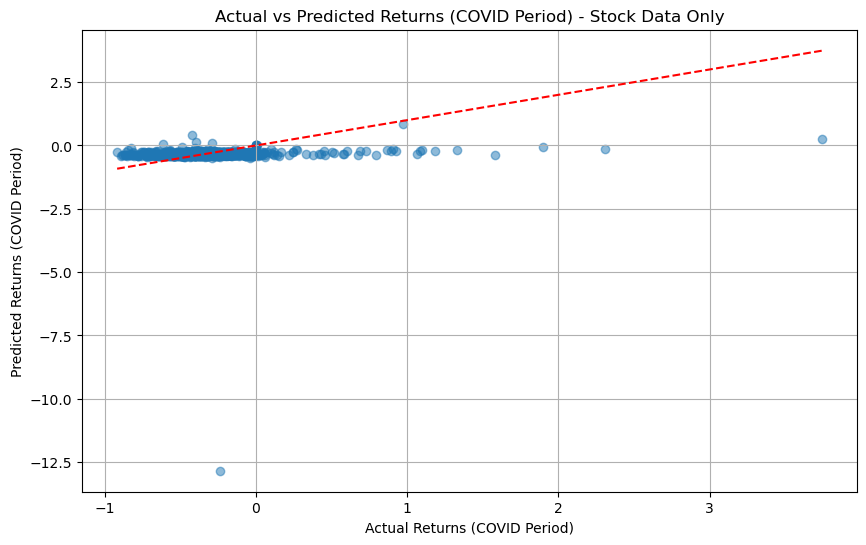

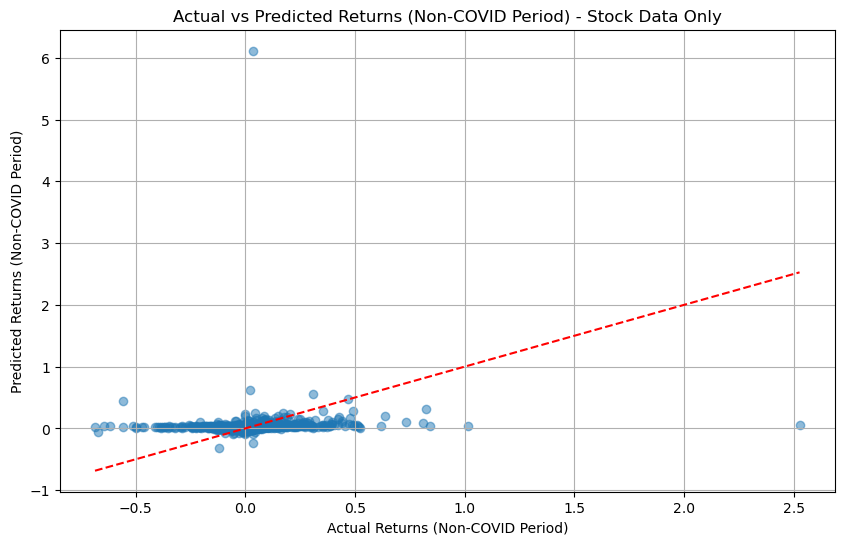

In [61]:
import matplotlib.pyplot as plt

# Plot for COVID Period
plt.figure(figsize=(10, 6))
plt.scatter(y_covid_test, y_covid_pred, alpha=0.5)
plt.plot([y_covid_test.min(), y_covid_test.max()], [y_covid_test.min(), y_covid_test.max()], 'r--')
plt.xlabel('Actual Returns (COVID Period)')
plt.ylabel('Predicted Returns (COVID Period)')
plt.title('Actual vs Predicted Returns (COVID Period) - Stock Data Only')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/covid_period_scatter_plot_stock_only.png')
plt.show()

# Plot for Non-COVID Period
plt.figure(figsize=(10, 6))
plt.scatter(y_non_covid_test, y_non_covid_pred, alpha=0.5)
plt.plot([y_non_covid_test.min(), y_non_covid_test.max()], [y_non_covid_test.min(), y_non_covid_test.max()], 'r--')
plt.xlabel('Actual Returns (Non-COVID Period)')
plt.ylabel('Predicted Returns (Non-COVID Period)')
plt.title('Actual vs Predicted Returns (Non-COVID Period) - Stock Data Only')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/non_covid_period_scatter_plot_stock_only.png')
plt.show()

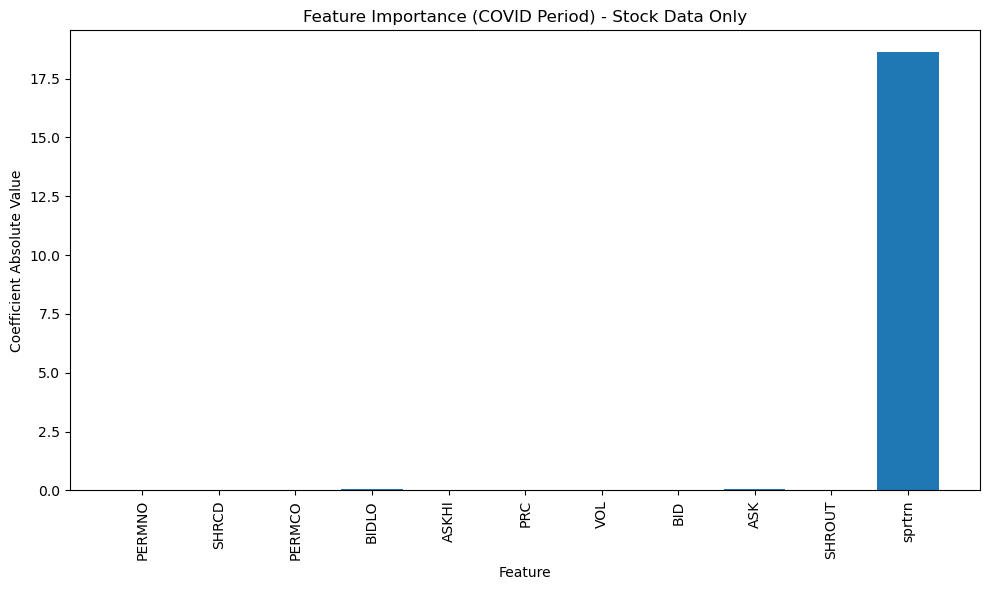

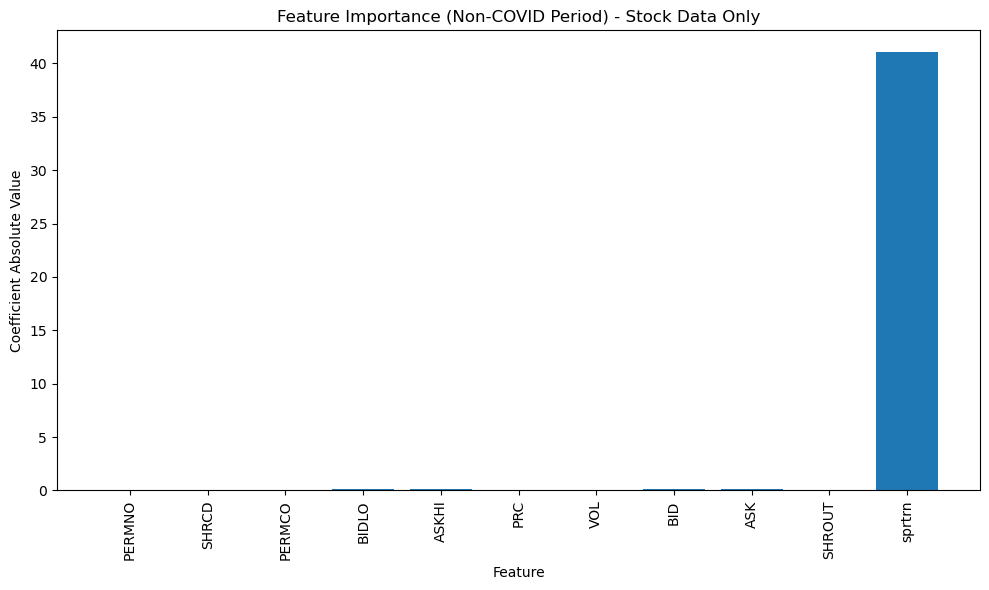

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the coefficients and feature names for the COVID period (stock-only model)
coefficients_covid = model_covid.params.values[1:]  # Skip the constant term
features_covid = X_covid_train.columns

# Extract the coefficients and feature names for the Non-COVID period (stock-only model)
coefficients_non_covid = model_non_covid.params.values[1:]  # Skip the constant term
features_non_covid = X_non_covid_train.columns

# Plot feature importance for the COVID period (stock-only)
plt.figure(figsize=(10, 6))
plt.bar(features_covid, np.abs(coefficients_covid))
plt.title("Feature Importance (COVID Period) - Stock Data Only")
plt.xlabel("Feature")
plt.ylabel("Coefficient Absolute Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/feature_importance_covid_stock.png')
plt.show()

# Plot feature importance for the Non-COVID period (stock-only)
plt.figure(figsize=(10, 6))
plt.bar(features_non_covid, np.abs(coefficients_non_covid))
plt.title("Feature Importance (Non-COVID Period) - Stock Data Only")
plt.xlabel("Feature")
plt.ylabel("Coefficient Absolute Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/feature_importance_non_covid_stock.png')
plt.show()

# Incorporating Fama French data

In [63]:
import pandas as pd

# Load the Fama-French factors data
fama_french_data = pd.read_csv('/Users/rohanpadaya/Downloads/F-F_Research_Data_Factors.CSV', skiprows=3)

# Rename the columns for clarity
fama_french_data.columns = ['Date', 'Mkt_RF', 'SMB', 'HML', 'RF']

# Remove rows where 'Date' is NaN
fama_french_data = fama_french_data.dropna(subset=['Date'])

# Filter out any non-date rows in the 'Date' column
fama_french_data = fama_french_data[fama_french_data['Date'].str.isnumeric()]

# Convert the 'Date' column to a datetime format
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%Y%m').dt.to_period('M')

# Filter the Fama-French data for the relevant periods (December 2019 - March 2020)
fama_french_data = fama_french_data[(fama_french_data['Date'] >= '2019-12') & (fama_french_data['Date'] <= '2020-03')]

# Check the data
print(fama_french_data.head())


         Date    Mkt_RF       SMB       HML        RF
1121  2019-12      2.77      0.73      1.78      0.14
1122  2020-01     -0.11     -3.13     -6.25      0.13
1123  2020-02     -8.13      1.07     -3.80      0.12
1124  2020-03    -13.39     -4.79    -13.88      0.13


In [64]:
fama_french_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1121 to 1124
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   Date    4 non-null      period[M]
 1   Mkt_RF  4 non-null      object   
 2   SMB     4 non-null      object   
 3   HML     4 non-null      object   
 4   RF      4 non-null      object   
dtypes: object(4), period[M](1)
memory usage: 192.0+ bytes


In [65]:
# Convert the Fama-French factors (Mkt_RF, SMB, HML, RF) to numeric
fama_french_data[['Mkt_RF', 'SMB', 'HML', 'RF']] = fama_french_data[['Mkt_RF', 'SMB', 'HML', 'RF']].apply(pd.to_numeric)

# Check the data types to ensure the conversion was successful
print(fama_french_data.dtypes)
print(fama_french_data.head())


Date      period[M]
Mkt_RF      float64
SMB         float64
HML         float64
RF          float64
dtype: object
         Date  Mkt_RF   SMB    HML    RF
1121  2019-12    2.77  0.73   1.78  0.14
1122  2020-01   -0.11 -3.13  -6.25  0.13
1123  2020-02   -8.13  1.07  -3.80  0.12
1124  2020-03  -13.39 -4.79 -13.88  0.13


In [66]:
# Align and merge stock returns with Fama-French factors
merged_data = pd.merge(stock_data_1_cleaned, fama_french_data, how='inner', left_on=stock_data_1_cleaned['date'].dt.to_period('M'), right_on='Date')


In [67]:
print(merged_data.head())

   PERMNO       date  SHRCD TICKER                  COMNAM  PERMCO   BIDLO  \
0   10026 2019-12-02   11.0   JJSF  J & J SNACK FOODS CORP    7976  182.73   
1   10026 2019-12-03   11.0   JJSF  J & J SNACK FOODS CORP    7976  183.06   
2   10026 2019-12-04   11.0   JJSF  J & J SNACK FOODS CORP    7976  186.72   
3   10026 2019-12-05   11.0   JJSF  J & J SNACK FOODS CORP    7976  186.20   
4   10026 2019-12-06   11.0   JJSF  J & J SNACK FOODS CORP    7976  187.97   

       ASKHI        PRC       VOL       RET        BID        ASK   SHROUT  \
0  186.41000  184.25000  121203.0 -0.004054  183.97000  184.17999  18899.0   
1  187.06000  186.94000  112357.0  0.014600  186.97000  187.08000  18899.0   
2  189.21001  188.10001   63753.0  0.006205  188.00999  188.24001  18899.0   
3  188.24001  188.00999   93226.0 -0.000479  188.00999  188.25000  18899.0   
4  189.80000  188.80000   65086.0  0.004202  188.80000  188.98000  18899.0   

     sprtrn     Date  Mkt_RF   SMB   HML    RF  
0 -0.008631  

In [68]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629565 entries, 0 to 629564
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   PERMNO  629565 non-null  int64         
 1   date    629565 non-null  datetime64[ns]
 2   SHRCD   629565 non-null  float64       
 3   TICKER  629565 non-null  object        
 4   COMNAM  629565 non-null  object        
 5   PERMCO  629565 non-null  int64         
 6   BIDLO   629565 non-null  float64       
 7   ASKHI   629565 non-null  float64       
 8   PRC     629565 non-null  float64       
 9   VOL     629565 non-null  float64       
 10  RET     629565 non-null  float64       
 11  BID     629565 non-null  float64       
 12  ASK     629565 non-null  float64       
 13  SHROUT  629565 non-null  float64       
 14  sprtrn  629565 non-null  float64       
 15  Date    629565 non-null  period[M]     
 16  Mkt_RF  629565 non-null  float64       
 17  SMB     629565 non-null  floa

In [69]:
import statsmodels.api as sm

# Function to calculate betas for each stock
def calculate_betas(stock_df):
    X = stock_df[['Mkt_RF', 'SMB', 'HML']]
    y = stock_df['RET'] - stock_df['RF']  # Excess returns
    X = sm.add_constant(X)  # Add constant term (intercept)
    model = sm.OLS(y, X).fit()  # Fit OLS regression
    return model.params

# Apply the function to each stock's data to calculate betas
betas = merged_data.groupby('PERMNO').apply(calculate_betas)

# Convert the multi-index series to a DataFrame
betas_df = betas.unstack()  # This will automatically align columns

# Rename the columns
betas_df.columns = ['Alpha', 'Mkt_RF_Beta', 'SMB_Beta', 'HML_Beta']

# Display the first few rows of the betas DataFrame
print(betas_df.head())


           Alpha  Mkt_RF_Beta  SMB_Beta  HML_Beta
PERMNO                                           
10026  -0.010563     0.004256  0.017416 -0.145708
10028  -0.030002     0.013579  0.043067 -0.157237
10032  -0.008439     0.003289  0.013626 -0.143339
10044  -0.010936     0.004887  0.018442 -0.144970
10051  -0.009576     0.004078  0.016430 -0.143693


In [70]:
betas_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7750 entries, 10026 to 93436
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Alpha        7750 non-null   float64
 1   Mkt_RF_Beta  7750 non-null   float64
 2   SMB_Beta     7750 non-null   float64
 3   HML_Beta     7671 non-null   float64
dtypes: float64(4)
memory usage: 302.7 KB


In [71]:
betas_df.describe()

,Alpha,Mkt_RF_Beta,SMB_Beta,HML_Beta
count,7750.000000,7750.000000,7750.000000,7671.000000
mean,-0.009457,0.003636,0.014608,-0.141524
std,0.010157,0.006841,0.015107,0.018379
min,-0.130534,-0.086264,-0.246814,-0.292620
25%,-0.012422,0.002990,0.011624,-0.146447
50%,-0.010008,0.004192,0.015476,-0.143997
75%,-0.007377,0.005473,0.019110,-0.141208
max,0.148836,0.065173,0.210670,0.012623


In [72]:
# Define the periods
covid_period_start = '2020-02-14'
covid_period_end = '2020-03-20'
non_covid_period_start = '2019-12-14'
non_covid_period_end = '2020-01-20'

# Function to compute cumulative returns
def compute_cumulative_return(data, start_date, end_date):
    period_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    cumulative_returns = period_data.groupby('PERMNO')['RET'].apply(lambda x: (1 + x).prod() - 1)
    return cumulative_returns

# Compute returns for both periods
covid_returns = compute_cumulative_return(merged_data, covid_period_start, covid_period_end)
non_covid_returns = compute_cumulative_return(merged_data, non_covid_period_start, non_covid_period_end)

# Align returns by PERMNO
covid_returns_aligned, non_covid_returns_aligned = covid_returns.align(non_covid_returns, join='inner')

# Create a DataFrame with aligned indices
returns_df = pd.DataFrame({
    'PERMNO': covid_returns_aligned.index,
    'COVID_Return': covid_returns_aligned.values,
    'Non_COVID_Return': non_covid_returns_aligned.values
})


In [73]:
returns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7557 entries, 0 to 7556
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PERMNO            7557 non-null   int64  
 1   COVID_Return      7557 non-null   float64
 2   Non_COVID_Return  7557 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 177.2 KB


In [74]:
# Merge the returns with the betas
analysis_data = returns_df.merge(betas_df, on='PERMNO', how='left')

# Select additional explanatory variables
additional_vars = merged_data.groupby('PERMNO').agg({
    'BIDLO': 'mean',
    'ASKHI': 'mean',
    'PRC': 'mean',
    'VOL': 'mean',
    'BID': 'mean',
    'ASK': 'mean',
    'SHROUT': 'mean',
    'sprtrn': 'mean'
}).reset_index()

# Merge with the analysis data
final_analysis_data = analysis_data.merge(additional_vars, on='PERMNO', how='left')

# Check the final dataset
print(final_analysis_data.head())


   PERMNO  COVID_Return  Non_COVID_Return     Alpha  Mkt_RF_Beta  SMB_Beta  \
0   10026     -0.280867          0.019054 -0.010563     0.004256  0.017416   
1   10028      0.048427          0.094407 -0.030002     0.013579  0.043067   
2   10032     -0.427277          0.006751 -0.008439     0.003289  0.013626   
3   10044     -0.539688         -0.005038 -0.010936     0.004887  0.018442   
4   10051     -0.463254         -0.014268 -0.009576     0.004078  0.016430   

   HML_Beta       BIDLO       ASKHI         PRC            VOL         BID  \
0 -0.145708  165.027896  169.904705  167.465543  120403.951807  167.278554   
1 -0.157237    1.942495    2.144381    2.050382  145349.361446    2.040241   
2 -0.143339   68.827316   71.292771   69.948253  183913.734940   69.875301   
3 -0.144970    7.924998    8.265977    8.029616   16351.301205    7.989639   
4 -0.143693   23.264778   24.177813   23.702771  263344.746988   23.676747   

          ASK        SHROUT    sprtrn  
0  167.555181  18909.6

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Define the features (X) and target (y) for COVID period
X_covid = final_analysis_data.drop(columns=['PERMNO', 'COVID_Return', 'Non_COVID_Return'])
y_covid = final_analysis_data['COVID_Return']

# Define the features (X) and target (y) for Non-COVID period
X_non_covid = final_analysis_data.drop(columns=['PERMNO', 'COVID_Return', 'Non_COVID_Return'])
y_non_covid = final_analysis_data['Non_COVID_Return']

# Split the data into training and testing sets
X_train_covid, X_test_covid, y_train_covid, y_test_covid = train_test_split(X_covid, y_covid, test_size=0.2, random_state=42)
X_train_non_covid, X_test_non_covid, y_train_non_covid, y_test_non_covid = train_test_split(X_non_covid, y_non_covid, test_size=0.2, random_state=42)


In [76]:
# Train the model on training data for the COVID period
covid_model = sm.OLS(y_train_covid, sm.add_constant(X_train_covid)).fit()

print(covid_model.summary())
# Train the model on training data for the Non-COVID period
non_covid_model = sm.OLS(y_train_non_covid, sm.add_constant(X_train_non_covid)).fit()
print(non_covid_model.summary())


                            OLS Regression Results                            
Dep. Variable:           COVID_Return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     540.5
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:51:12   Log-Likelihood:                 761.17
No. Observations:                6045   AIC:                            -1496.
Df Residuals:                    6032   BIC:                            -1409.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6439      0.080     32.969      

In [77]:
# Predictions on the test set for COVID period
y_pred_covid = covid_model.predict(sm.add_constant(X_test_covid))

# Predictions on the test set for Non-COVID period
y_pred_non_covid = non_covid_model.predict(sm.add_constant(X_test_non_covid))

# Evaluate the COVID period model
print("COVID Period MSE:", mean_squared_error(y_test_covid, y_pred_covid))
print("COVID Period R2:", r2_score(y_test_covid, y_pred_covid))

# Evaluate the Non-COVID period model
print("Non-COVID Period MSE:", mean_squared_error(y_test_non_covid, y_pred_non_covid))
print("Non-COVID Period R2:", r2_score(y_test_non_covid, y_pred_non_covid))


COVID Period MSE: 0.025213628818038007
COVID Period R2: 0.48717877682257327
Non-COVID Period MSE: 0.017886082583574797
Non-COVID Period R2: 0.2748501186990925


In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")
    return mse, rmse, mae, r2

# For COVID period
print("COVID Period Metrics:")
mse_covid, rmse_covid, mae_covid, r2_covid = evaluate_model(y_test_covid, y_pred_covid)

# For Non-COVID period
print("\nNon-COVID Period Metrics:")
mse_non_covid, rmse_non_covid, mae_non_covid, r2_non_covid = evaluate_model(y_test_non_covid, y_pred_non_covid)


COVID Period Metrics:
MSE: 0.025213628818038007
RMSE: 0.15878799960336426
MAE: 0.09984097985705556
R²: 0.48717877682257327

Non-COVID Period Metrics:
MSE: 0.017886082583574797
RMSE: 0.13373885966156132
MAE: 0.06514557304817395
R²: 0.2748501186990925


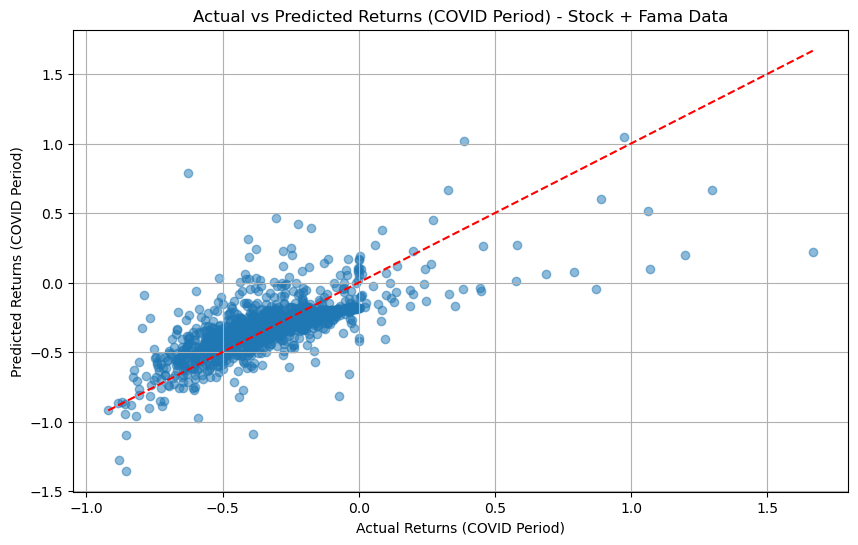

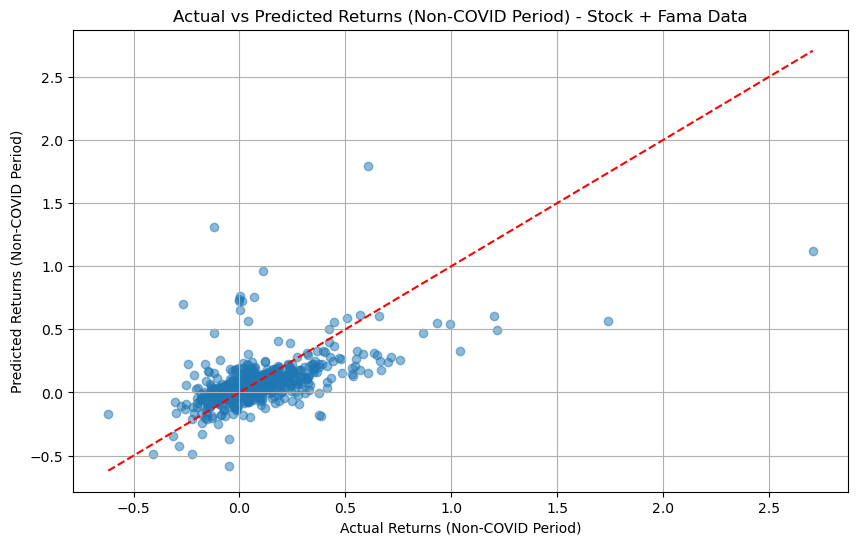

In [83]:
# Plot for COVID Period
plt.figure(figsize=(10, 6))
plt.scatter(y_test_covid, y_pred_covid, alpha=0.5)
plt.plot([y_test_covid.min(), y_test_covid.max()], [y_test_covid.min(), y_test_covid.max()], 'r--')
plt.xlabel('Actual Returns (COVID Period)')
plt.ylabel('Predicted Returns (COVID Period)')
plt.title('Actual vs Predicted Returns (COVID Period) - Stock + Fama Data')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/New2.png')
plt.show()

# Plot for Non-COVID Period
plt.figure(figsize=(10, 6))
plt.scatter(y_test_non_covid, y_pred_non_covid, alpha=0.5)
plt.plot([y_test_non_covid.min(), y_test_non_covid.max()], [y_test_non_covid.min(), y_test_non_covid.max()], 'r--')
plt.xlabel('Actual Returns (Non-COVID Period)')
plt.ylabel('Predicted Returns (Non-COVID Period)')
plt.title('Actual vs Predicted Returns (Non-COVID Period) - Stock + Fama Data')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/New1.png')
plt.show()

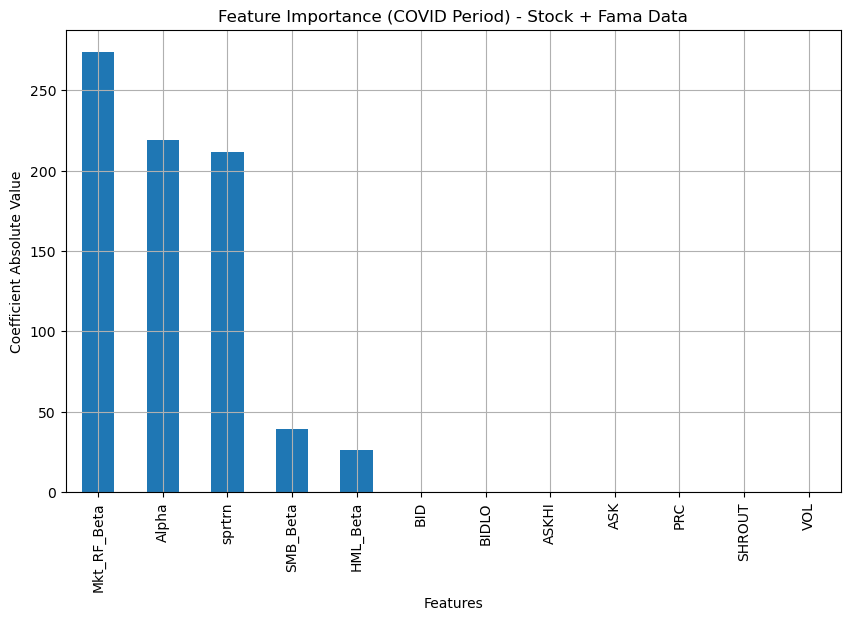

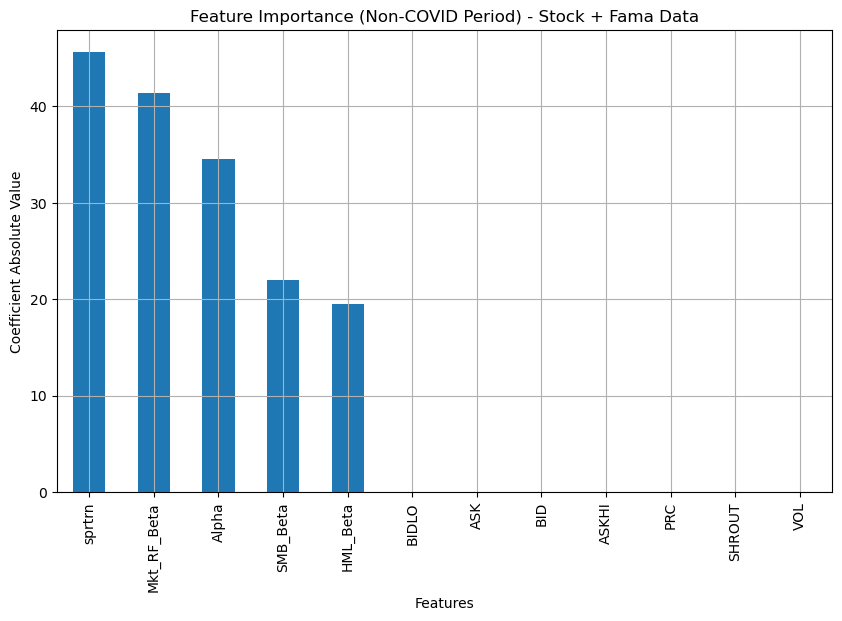

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming covid_model and non_covid_model are your trained models
# and X_train_covid, X_train_non_covid are your training data without the constant term

# Coefficient Plot for COVID Model
coefficients_covid = pd.Series(covid_model.params[1:], index=X_train_covid.columns)  # Exclude the constant
coefficients_covid = coefficients_covid.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients_covid.plot(kind='bar')
plt.title('Feature Importance (COVID Period) - Stock + Fama Data')
plt.ylabel('Coefficient Absolute Value')
plt.xlabel('Features')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/feature_importance_covid_fama.png')
plt.show()

# Coefficient Plot for Non-COVID Model
coefficients_non_covid = pd.Series(non_covid_model.params[1:], index=X_train_non_covid.columns)  # Exclude the constant
coefficients_non_covid = coefficients_non_covid.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients_non_covid.plot(kind='bar')
plt.title('Feature Importance (Non-COVID Period) - Stock + Fama Data')
plt.ylabel('Coefficient Absolute Value')
plt.xlabel('Features')
plt.grid(True)
plt.savefig('/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/feature_importance_non_covid_fama.png')
plt.show()